# EEG Classification Notebook with Kalman Filter

Here we classify the EEG signal using a CNN. To generate the ground truth labels, we apply a kalman filter to the feeltrace signal, and then generate the emotion labels from this new signal.

In [82]:
# import some useful libraries

import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from scipy import signal


# model creation
import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold, KFold

# loading bar
from tqdm import tqdm

# kalman filter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


## Load Dataset

In [106]:
dir = '../eeg_feeltrace' # directory containing *.csv files
# hyper parameters
window_size = 1000 # must be an int in milliseconds
overlap = 0.0 # overlap %
subject_num = 5 # which subject to choose [1-16]
k_fold = 5 # k for k fold validation
apply_kf = True # apply kalman filter
label_type = 'angle' # 'angle' or 'pos' or 'both'
num_classes = 3 if label_type != 'both' else 9 # number of classes to discretize the labels into
num_features = 64 # eeg feature size
classifier_learning_rate = 1e-3 # adam learning rate
classifier_train_epochs = 10 # train classifier duration
classifier_hidden = 8 # classifier parameter, the larger the more complicated the model

In [107]:
# functions for preprocessing dataset
# The features are 5x64x64 images (Channel,Height,Width)

def load_dataset(dir = 'feeltrace', subject_num = 5):
    # choose the subject
    subject_data_files = glob.glob(os.path.join(dir, 'eeg_ft_*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.csv')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    eeg_ft = subject_data_files[subject_num-1]

    

    print(f"Chosen subject: {eeg_ft}")
    
    data_signal = pd.read_csv(eeg_ft) # read the Nx(1+1+64) data for a single subject
    # return signal
    return data_signal, -1

def generate_label(eeg_ft, split_size=100, k=5, label_type='angle', num_classes=3, kf=False, overlap=0.0):

    # split into windows (with overlap %)
    dataset = [eeg_ft[x : x + split_size] for x in range(0, len(eeg_ft), int(split_size * (1.0-overlap)))]
    dataset = [x for x in dataset if len(x) == split_size] # remove last windows if they are smaller than the rest

    if label_type != 'both':
        labels, raw_label = get_label(dataset, n_labels=num_classes, label_type=label_type, kf=kf, dt=split_size/1000) # (N, 1)
    else:
        labels, raw_label = get_combined_label(dataset, n_labels=int(np.sqrt(num_classes))) # (N, 1)

    dataset = generate_eeg_features(dataset)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)

    print(f"EEG feature shape (N, freq_bands, channels, channels):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k) # split data into train/test indices using kFold validation
    return dataset, labels, indices, raw_label


def apply_kalman(raw_label, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,1.]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(raw_label)
    for i,m in enumerate(raw_label):
        kf.predict() # predict
        kf.update(m) # measure
        x = np.clip(kf.x[0], 0,1)
        kf_signal[i] = x
    return kf_signal


def generate_regression_label(eeg_ft, split_size=100, k=5, kf=False):
    # if kf:
    #     apply_kalman(eeg_ft, dt=split_size/1000)

    # split into windows (non-overlapping)
    dataset = [eeg_ft[x : x + split_size] for x in range(0, len(eeg_ft), split_size)]
    if len(dataset[-1]) < split_size:
        dataset.pop() # remove last window if it is smaller than the rest


    _, pos_raw_label = get_label(dataset, n_labels=3, label_type='pos') # (N, 1)
    _, angle_raw_label = get_label(dataset, n_labels=3, label_type='angle') # (N, 1)

    raw_label = np.hstack([pos_raw_label[:, None], angle_raw_label[:,None]])

    if kf:
        labels = apply_kalman_regression(raw_label, dt=split_size/1000)
    else:
        labels = raw_label


    dataset = generate_eeg_features(dataset)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)

    print(f"EEG feature shape (N, freq_bands, channels, channels):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k, strat=False) # split data into train/test indices using kFold validation
    return dataset, labels , indices, raw_label

def apply_kalman_regression(labels, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,0.],
    [0, 1]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(labels)
    for i,m in enumerate(labels):
        kf.predict() # predict
        kf.update(m[:,None]) # measure
        kf_signal[i] = kf.x.squeeze()

    # re normalize to [0,1]
    kf_signal = (kf_signal - kf_signal.min(axis=0, keepdims=True)) / (kf_signal.max(axis=0, keepdims=True) - kf_signal.min(axis=0, keepdims=True))
    return kf_signal


def get_label(data, n_labels=3, label_type='angle', kf=False, dt=1e-3):
    if label_type == 'angle':
        labels = stress_2_angle(np.vstack([x[:,1].T for x in data])) # angle/slope mapped to [0,1] in a time window
    elif label_type == 'pos':
        labels = np.vstack([x[:,1].mean() for x in data]) # mean value within the time window
    else:
        labels = stress_2_accumulator(np.vstack([x[:,1].T for x in data])) # accumulator mapped to [0,1] in a time window

    if kf:
        labels = apply_kalman(labels, dt, R=1e3, var=1e3, p=1e3)
        
    label_dist = stress_2_label(labels, n_labels=n_labels).squeeze()
    return label_dist, labels.squeeze()

def get_combined_label(data, n_labels=3):
    angle_labels, _ = get_label(data, n_labels=n_labels, label_type='angle') # (N, 1)
    pos_labels, _ = get_label(data, n_labels=n_labels, label_type='pos') # (N, 1)

    labels = [x for x in range(n_labels)]
    labels_dict =  {(a, b) : n_labels*a+b for a in labels for b in labels} # cartesian product
    combined_labels = [labels_dict[(pos, angle)] for (pos, angle) in zip(pos_labels, angle_labels)]
    return np.array(combined_labels)


def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

def stress_2_angle(stress_windows):
    '''
    do a linear least squares fit in the time window
    stress_window: (N_samples, time_window)
    '''
    xvals = np.arange(stress_windows.shape[-1])/1e3/60 # time in (minutes)
    slope = np.polyfit(xvals, stress_windows.T, 1)[0] # take slope linear term # 1/s
    angle = np.arctan(slope)/ (np.pi/2) * 0.5 + 0.5 # map to [0,1]
    return angle

def stress_2_accumulator(stress_windows):
    '''
    apply an integral to the time window
    stress_window: (N_samples, time_window)
    '''
    max_area = stress_windows.shape[-1]
    xvals = np.arange(stress_windows.shape[-1]) # time in (ms)
    integral = np.trapz(stress_windows, x=xvals)
    return integral/max_area # map to [0,1]

def split_dataset(labels, k=5, strat=True):
    '''
    split the features and labels into k groups for k fold validation
    we use StratifiedKFold to ensure that the class distributions within each sample is the same as the global distribution
    '''
    if strat:
        kf = StratifiedKFold(n_splits=k, shuffle=True)
    else:
        kf = KFold(n_splits=k, shuffle=True)

    # only labels are required for generating the split indices so we ignore it
    temp_features = np.zeros_like(labels)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(temp_features, labels)]
    return indices

def generate_eeg_features(dataset):
    sample_freq = 1000
    # get FFT
    psd_windows = [signal.periodogram(x[:,2:], sample_freq, window='hamming', axis=0) for x in dataset ] # get the power spectral density for each window

    # frequency bands
    bands={'alpha': (8, 12), 'beta': (12, 30), 'delta': (1, 4), 'theta': (4, 7), 'gamma': (30, 50)}
    chosen_bands = ['alpha', 'beta', 'delta', 'theta', 'gamma']
    band_freqs = [bands[x] for x in chosen_bands]

    features = []
    for window in psd_windows: # calculate the power in each band for channel for each window
        freqs, psd = window
        idx_bands = [np.logical_and(freqs >= low, freqs <= high) for low,high in band_freqs]

        freq_res = freqs[1] - freqs[0]
        band_powers = np.array([sp.integrate.simpson(psd[idx,:], dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        total_powers = np.array([sp.integrate.simpson(psd, dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        diff_entropy = -0.5 * np.log(band_powers/total_powers)
        # (5, 1, 64)
        # (5, 64, 1)
        diff_de = np.expand_dims(diff_entropy, axis=2) - np.expand_dims(diff_entropy, axis=1) # (5,64,64)
        diff_de = (diff_de  - diff_de.min(axis=(1,2), keepdims=True))/(diff_de.max(axis=(1,2), keepdims=True) - diff_de.min(axis=(1,2), keepdims=True))
        
        features.append(diff_de)
    return features

In [15]:
eeg_ft_signal, scenes_df = load_dataset(dir = dir, subject_num = subject_num)

Chosen subject: ../eeg_feeltrace/eeg_ft_4.csv


EEG feature shape (N, freq_bands, channels, channels):  (568, 5, 64, 64)
label set shape (N,):  (568,)
EEG feature shape (N, freq_bands, channels, channels):  (568, 5, 64, 64)
label set shape (N,):  (568,)
Label class bincount: [ 90 371 107]


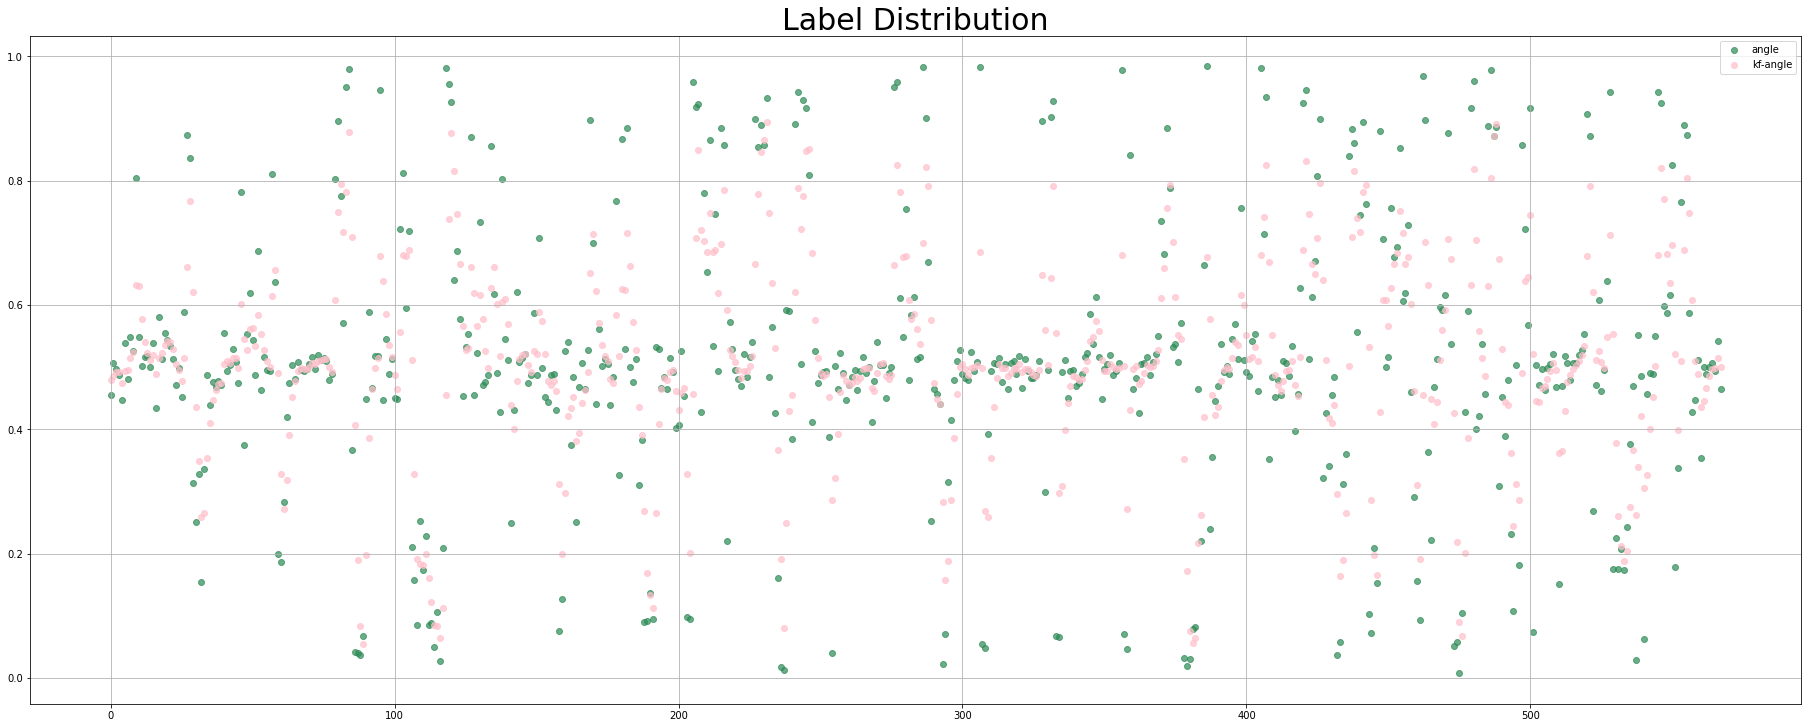

In [108]:
eeg_features, _, _, kf_raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=apply_kf, overlap=overlap)
_, labels, indices, raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=False, overlap=overlap)
print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


fsize = 30

fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
axes.scatter(np.arange(len(labels)), raw_label, alpha=0.7, color='seagreen', label=label_type)
axes.scatter(np.arange(len(labels)), kf_raw_label, alpha=0.7, color='pink', label='kf-'+label_type )
axes.grid('on', linestyle='-')
axes.set_aspect('auto')
axes.set_title('Label Distribution', fontsize=fsize)
axes.legend(loc='best')
plt.show()

In [83]:
# eeg_features, labels, indices, raw_label = generate_regression_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, kf=apply_kf)
# #print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


# fsize = 30

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,0], alpha=0.7, color='seagreen', label='position')
# axes.scatter(np.arange(len(labels)), labels[:,0], alpha=0.7, color='slateblue', label='kf-position')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,1], alpha=0.7, color='pink', label='angle')
# axes.scatter(np.arange(len(labels)), labels[:,1], alpha=0.7, color='gray', label='kf-angle')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()



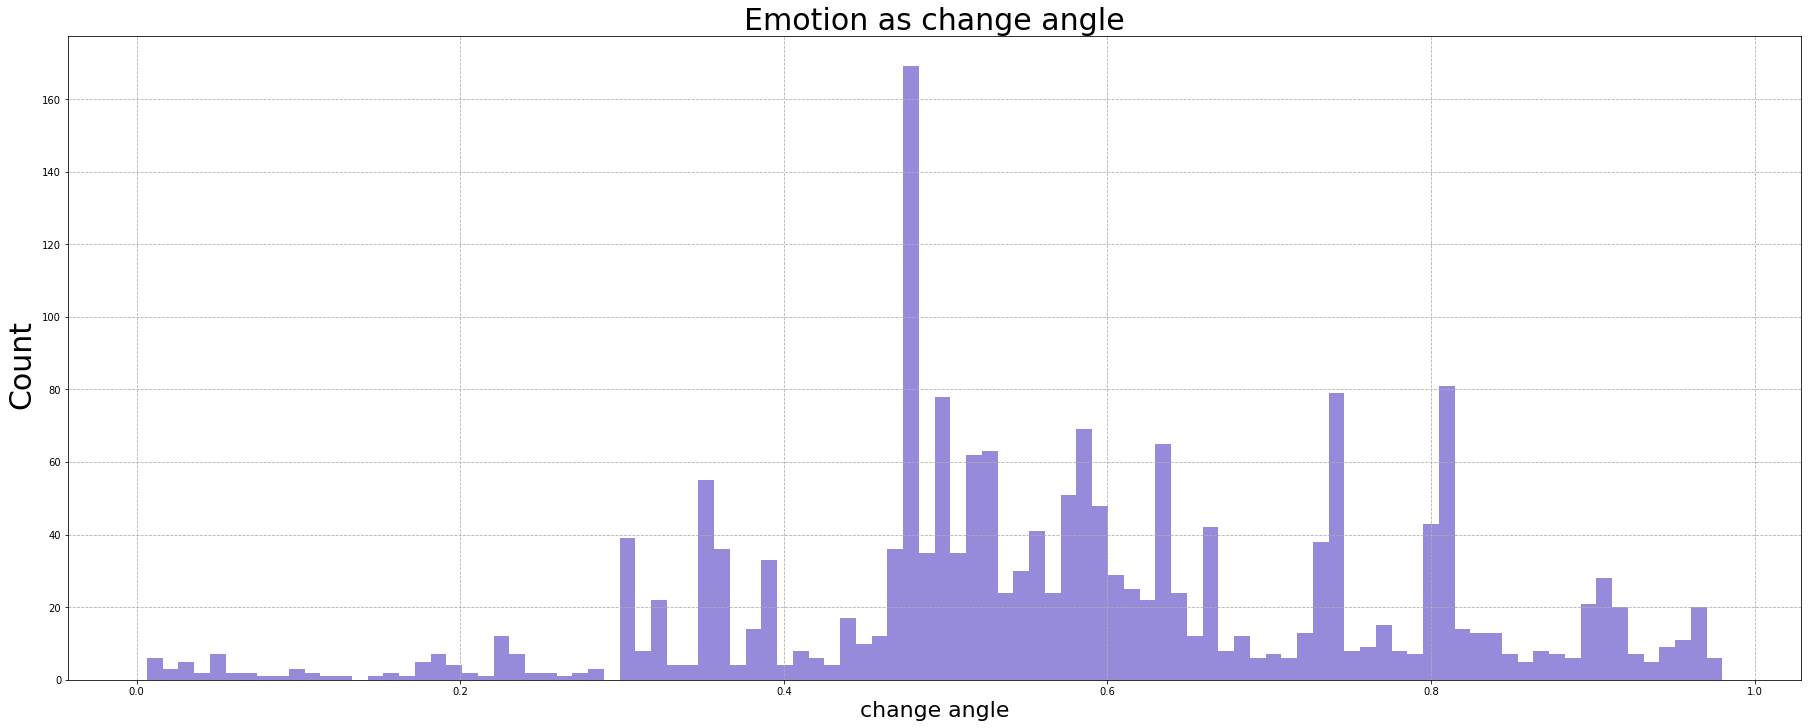

In [102]:
fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
n_bins = 100
fsize = 30
lsize = 22

axes.hist(kf_raw_label, histtype='stepfilled', alpha=0.7, bins=n_bins, color='slateblue', label='position')
axes.grid('on', linestyle='--')
axes.set_aspect('auto')
axes.set_title('Emotion as change angle', fontsize=fsize)
axes.set_xlabel('change angle', fontsize=lsize)


fig.supylabel('Count', fontsize=fsize)
plt.show()


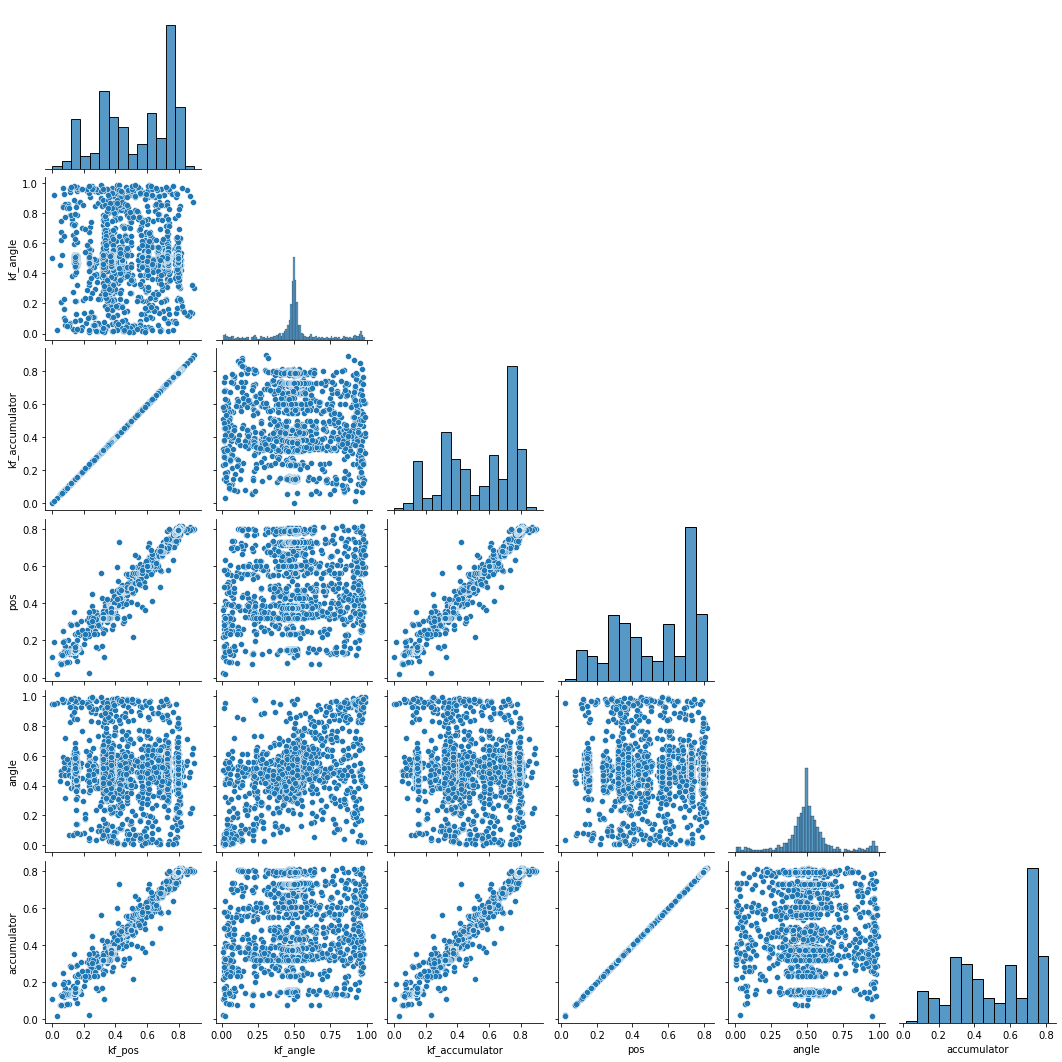

In [26]:
import seaborn as sns
g = sns.pairplot(data=label_df[["kf_pos", "kf_angle", "kf_accumulator", "pos", "angle", "accumulator"]], corner=True)
plt.show()
del g

## EEG Classifier and Training Function

In [109]:
class classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=5):
        super(classifier, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same', padding_mode='circular'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes))
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class regressor(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=2):
        super(regressor, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes),
            nn.Sigmoid())
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        'Initialization'
        self.x = features # (N, eeg_feature_size, 64)
        self.labels = labels # (N, 1)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index]).float() # (eeg_feature_size, 64, 64)
        y = torch.from_numpy(np.array(self.labels[index])).long() # feel trace labels int value [0,n_labels]
        return x, y


def train_classifier(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None,  label_smoothing=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_labels = labels
    
    # get the weights of each class as 1/occurrence
    train_class_weight = np.bincount(train_labels, minlength=num_classes)
    print(f"Train label distribution: {train_class_weight}")
    train_class_weight = 1/train_class_weight
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    
    # sampler, weighted by the inverse of the occurrence
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},')
        
    return train_metrics


def train_regressor(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.MSELoss()
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            # metrics
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss}')
        
    return train_metrics

## Training Classifier Loop

Training k=0
Training Classifier!
Train label distribution: [ 72 296  86]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


Epoch:1,
Train Loss:1.1562329530715942,
Train Accuracy:0.32566964285714284,
Train Recall: 0.3277712441894935,
Train precision: 0.2484132841466679,
Train F1-Score:0.2534216201099319,


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch:2,
Train Loss:1.0902677774429321,
Train Accuracy:0.4212053571428571,
Train Recall: 0.3833177117000647,
Train precision: 0.2941743084089482,
Train F1-Score:0.28097025278837817,


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch:3,
Train Loss:1.0546929836273193,
Train Accuracy:0.451171875,
Train Recall: 0.4580940608308731,
Train precision: 0.48442825395980715,
Train F1-Score:0.43084680887480065,


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


Epoch:4,
Train Loss:1.0106161832809448,
Train Accuracy:0.4772321428571429,
Train Recall: 0.48653515816028076,
Train precision: 0.4749750435221015,
Train F1-Score:0.468685062257113,


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch:5,
Train Loss:0.9604421257972717,
Train Accuracy:0.5634486607142857,
Train Recall: 0.5591387770346314,
Train precision: 0.5600591347952765,
Train F1-Score:0.555681713718959,


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Epoch:6,
Train Loss:0.8917177319526672,
Train Accuracy:0.598828125,
Train Recall: 0.5917531236048418,
Train precision: 0.6027131802390001,
Train F1-Score:0.5846972061827834,


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch:7,
Train Loss:0.9015010595321655,
Train Accuracy:0.5657366071428571,
Train Recall: 0.573103840410955,
Train precision: 0.5833355074368753,
Train F1-Score:0.5635881940216612,


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch:8,
Train Loss:0.8105931878089905,
Train Accuracy:0.679296875,
Train Recall: 0.6831102405879271,
Train precision: 0.6950881114600169,
Train F1-Score:0.6747973343682728,


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Epoch:9,
Train Loss:0.788183867931366,
Train Accuracy:0.6372767857142857,
Train Recall: 0.6296570906936445,
Train precision: 0.6620015157844106,
Train F1-Score:0.6049102533746431,


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch:10,
Train Loss:0.7690312266349792,
Train Accuracy:0.6792410714285715,
Train Recall: 0.6725728242218849,
Train precision: 0.7003402616813947,
Train F1-Score:0.6730969441861359,
Test label distribution: [18 75 21]
Precision: 0.44435111989459813
Recall: 0.4358730158730159
F1-Score: 0.4353389287760811
Base line F1-Score: 0.2645502645502646
Accuracy: 0.5964912280701754
Metrics:
              precision    recall  f1-score   support

           0       0.27      0.17      0.21        18
           1       0.71      0.76      0.74        75
           2       0.35      0.38      0.36        21

    accuracy                           0.60       114
   macro avg       0.44      0.44      0.44       114
weighted avg       0.58      0.60      0.58       114



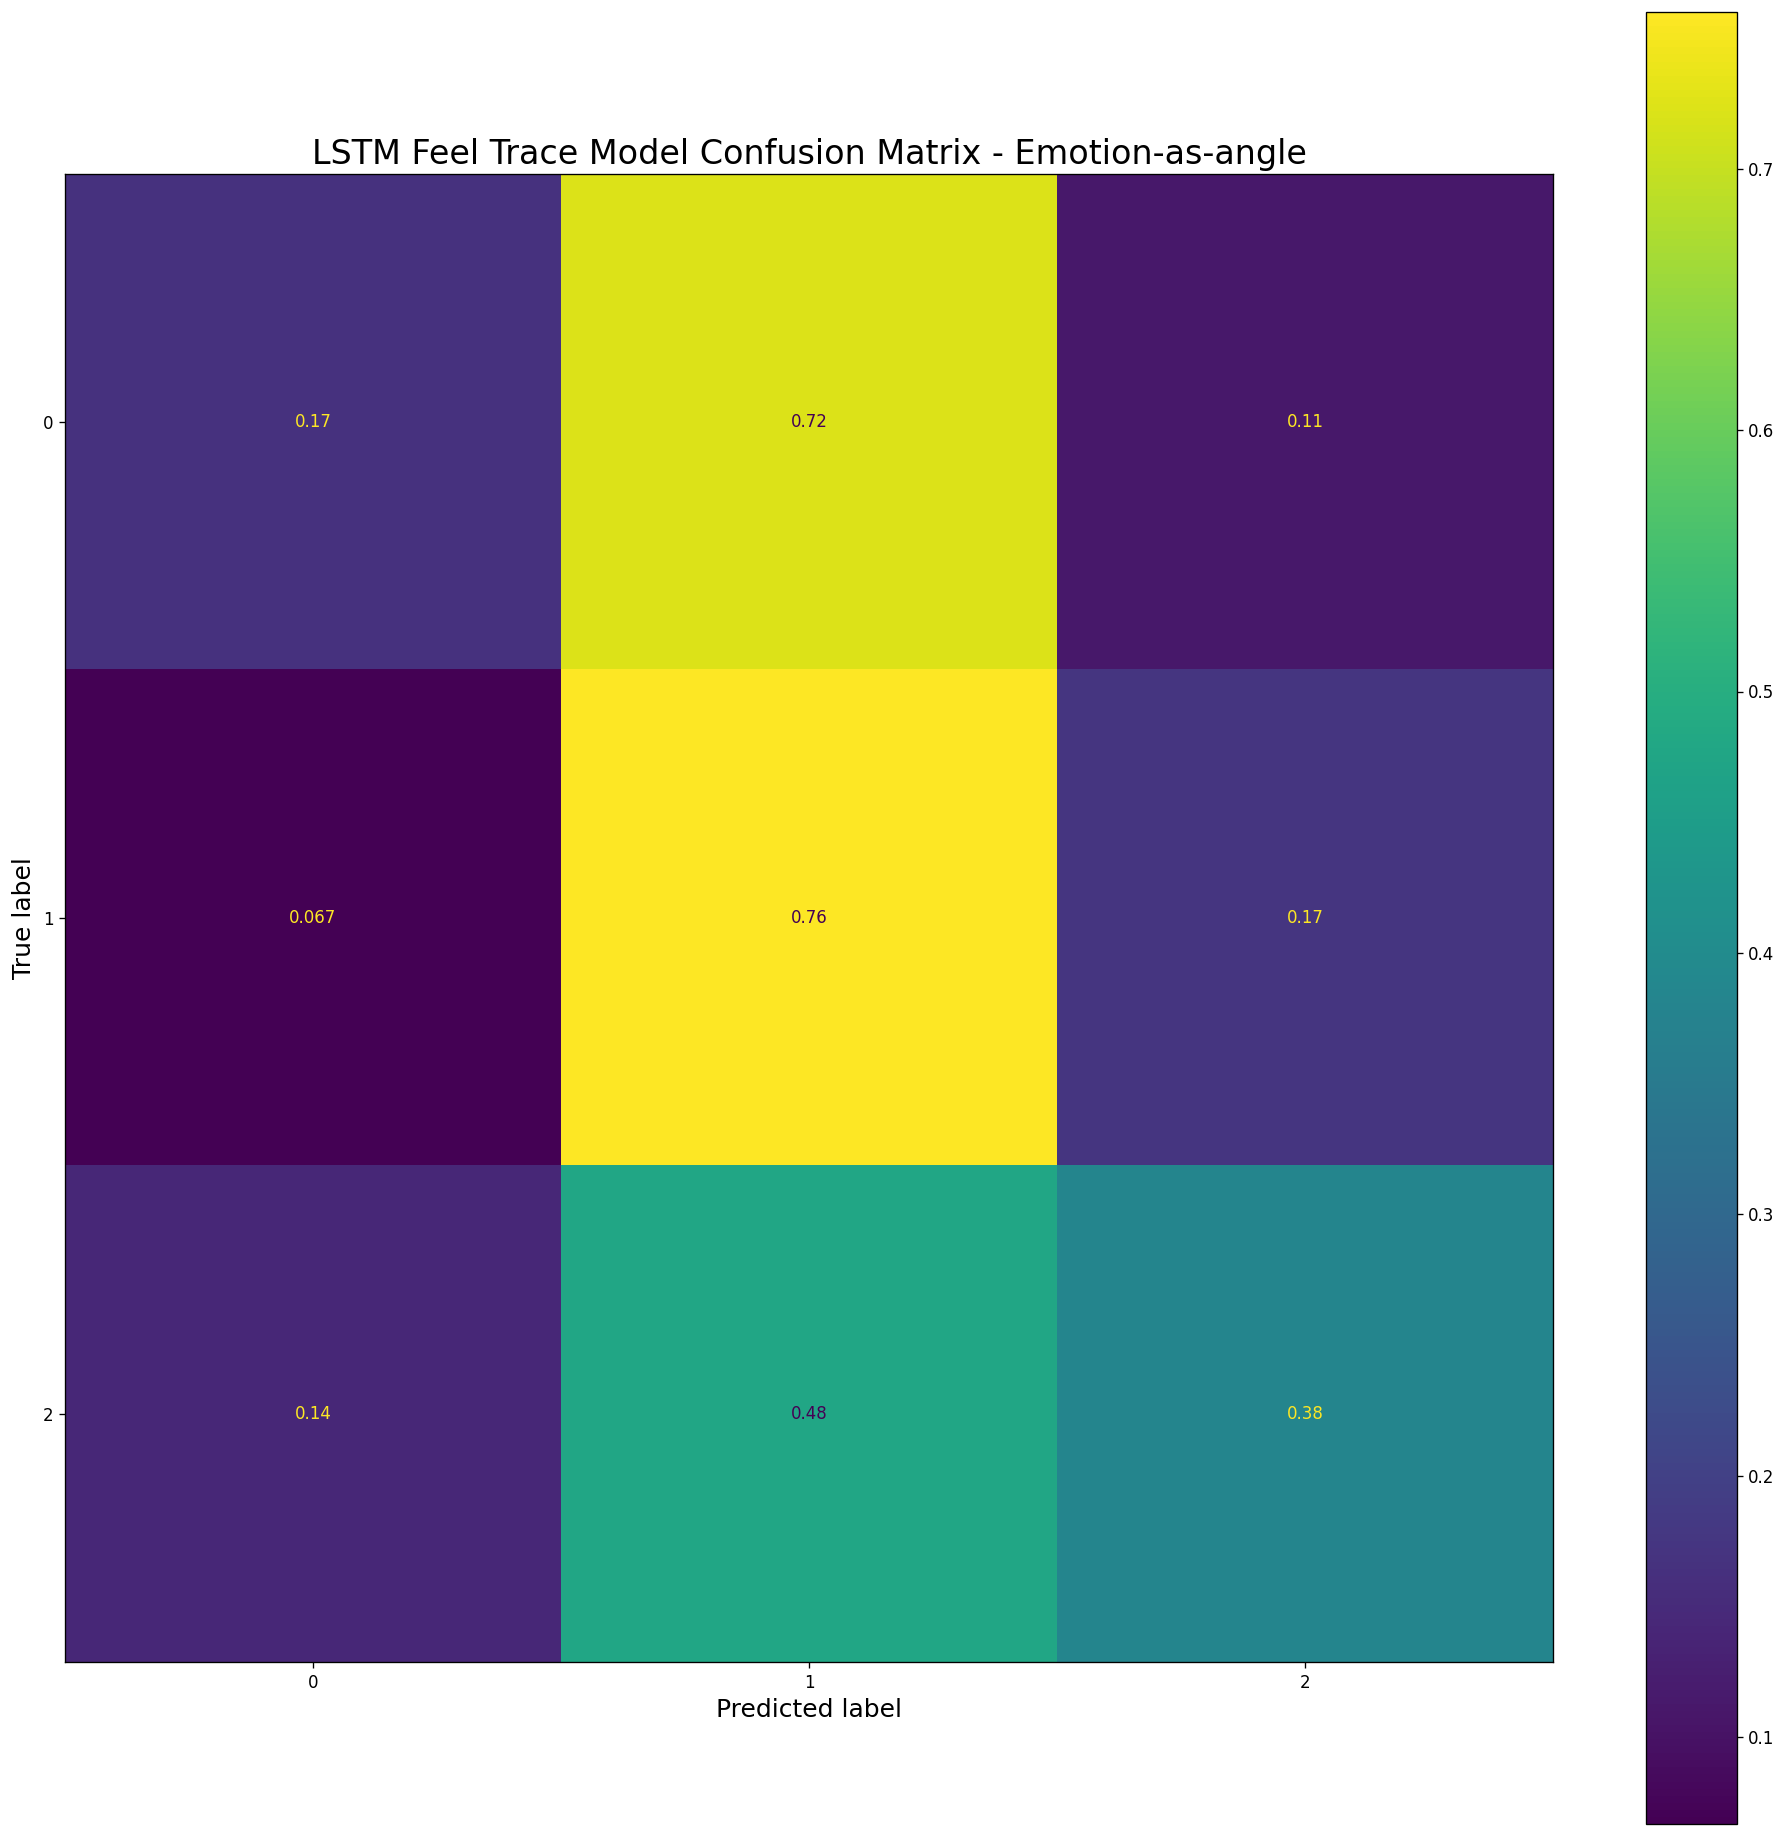

Training k=1
Training Classifier!
Train label distribution: [ 72 297  85]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Epoch:1,
Train Loss:1.1622920036315918,
Train Accuracy:0.35362723214285713,
Train Recall: 0.3591994870000298,
Train precision: 0.24579576165849143,
Train F1-Score:0.2681011143305282,


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch:2,
Train Loss:1.076314926147461,
Train Accuracy:0.3821986607142857,
Train Recall: 0.34240723826839475,
Train precision: 0.3335202641832175,
Train F1-Score:0.234655215155352,


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch:3,
Train Loss:1.0242844820022583,
Train Accuracy:0.43392857142857144,
Train Recall: 0.43667793257531473,
Train precision: 0.4635801227074812,
Train F1-Score:0.4090802943904029,


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch:4,
Train Loss:0.9805737137794495,
Train Accuracy:0.5403459821428571,
Train Recall: 0.5443985426687507,
Train precision: 0.5530888628384205,
Train F1-Score:0.5378603564633495,


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Epoch:5,
Train Loss:0.9505223035812378,
Train Accuracy:0.5595424107142857,
Train Recall: 0.5591656599245006,
Train precision: 0.5680851182263545,
Train F1-Score:0.5495778370538351,


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Epoch:6,
Train Loss:0.9173107147216797,
Train Accuracy:0.6015066964285715,
Train Recall: 0.6111215957097201,
Train precision: 0.6147395513059584,
Train F1-Score:0.6008628203855646,


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch:7,
Train Loss:0.8948417901992798,
Train Accuracy:0.5520647321428571,
Train Recall: 0.5430310286884917,
Train precision: 0.5594190117511879,
Train F1-Score:0.4981939445222299,


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch:8,
Train Loss:0.8608132600784302,
Train Accuracy:0.6054129464285715,
Train Recall: 0.5835413975035421,
Train precision: 0.6994276920175474,
Train F1-Score:0.5879507444419989,


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch:9,
Train Loss:0.8156107068061829,
Train Accuracy:0.6483258928571428,
Train Recall: 0.6160215980510124,
Train precision: 0.6308760457384675,
Train F1-Score:0.5877835671576447,


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch:10,
Train Loss:0.8467585444450378,
Train Accuracy:0.59296875,
Train Recall: 0.6072833318466032,
Train precision: 0.6651295458693459,
Train F1-Score:0.5581515941909275,
Test label distribution: [18 74 22]
Precision: 0.3350694444444444
Recall: 0.3367913367913367
F1-Score: 0.33000485403231394
Base line F1-Score: 0.2624113475177305
Accuracy: 0.45614035087719296
Metrics:
              precision    recall  f1-score   support

           0       0.13      0.11      0.12        18
           1       0.67      0.58      0.62        74
           2       0.20      0.32      0.25        22

    accuracy                           0.46       114
   macro avg       0.34      0.34      0.33       114
weighted avg       0.50      0.46      0.47       114



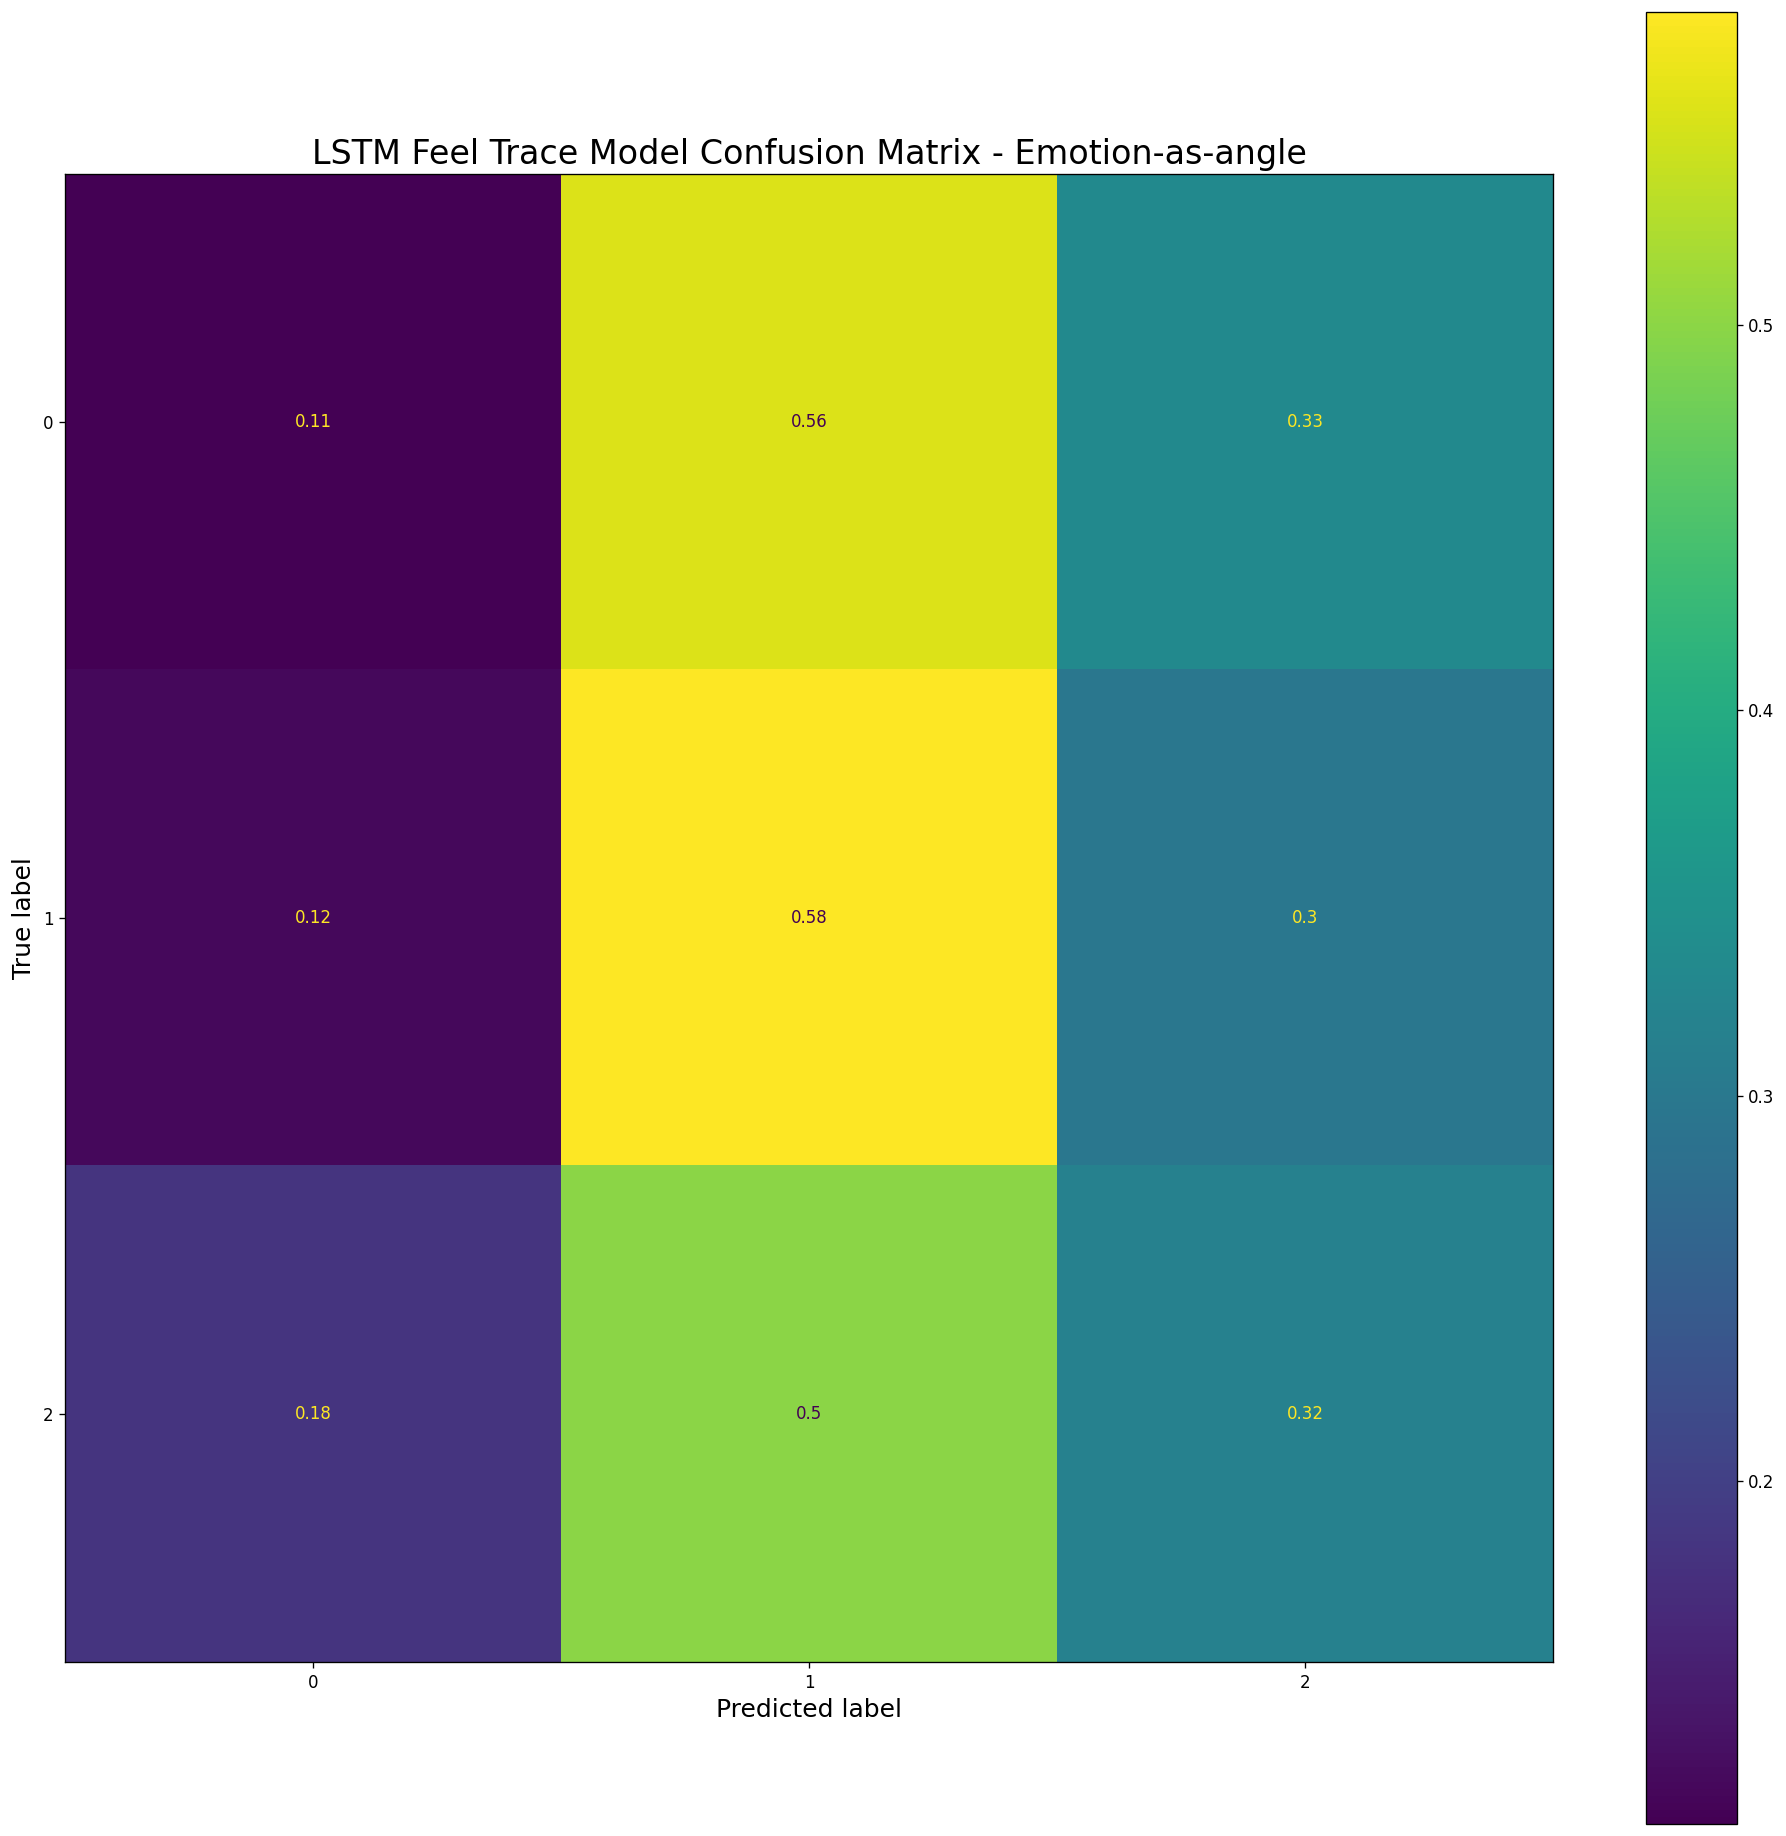

Training k=2
Training Classifier!
Train label distribution: [ 72 297  85]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


Epoch:1,
Train Loss:1.082409381866455,
Train Accuracy:0.4130580357142857,
Train Recall: 0.40758332904674366,
Train precision: 0.4454269014312321,
Train F1-Score:0.39007326104192386,


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch:2,
Train Loss:1.0603628158569336,
Train Accuracy:0.43526785714285715,
Train Recall: 0.4275817750855668,
Train precision: 0.4713913345302844,
Train F1-Score:0.3659016719613498,


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch:3,
Train Loss:1.0085170269012451,
Train Accuracy:0.47170758928571427,
Train Recall: 0.45352879051961825,
Train precision: 0.5242173870905213,
Train F1-Score:0.4284612152364758,


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch:4,
Train Loss:0.9991228580474854,
Train Accuracy:0.4772321428571429,
Train Recall: 0.48099349259154994,
Train precision: 0.49518825652448567,
Train F1-Score:0.45291997617163454,


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch:5,
Train Loss:0.967753529548645,
Train Accuracy:0.5559151785714286,
Train Recall: 0.5462166858905988,
Train precision: 0.5943715236121376,
Train F1-Score:0.5243898164222135,


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch:6,
Train Loss:0.9017647504806519,
Train Accuracy:0.599609375,
Train Recall: 0.6021277056550083,
Train precision: 0.6152460229736096,
Train F1-Score:0.5926877573703456,


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Epoch:7,
Train Loss:0.898093581199646,
Train Accuracy:0.6106026785714286,
Train Recall: 0.6211844858657329,
Train precision: 0.6260239297739297,
Train F1-Score:0.6016005725644074,


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch:8,
Train Loss:0.8960273265838623,
Train Accuracy:0.5890625,
Train Recall: 0.5948324517933473,
Train precision: 0.6043200689602065,
Train F1-Score:0.5802723606884456,


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch:9,
Train Loss:0.8811817765235901,
Train Accuracy:0.6138950892857142,
Train Recall: 0.6086736273190714,
Train precision: 0.6311222174094351,
Train F1-Score:0.5893054625707344,


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch:10,
Train Loss:0.8541637659072876,
Train Accuracy:0.6350446428571428,
Train Recall: 0.6352318393991567,
Train precision: 0.6417101073359753,
Train F1-Score:0.6322206845967655,
Test label distribution: [18 74 22]
Precision: 0.4039235925274613
Recall: 0.40176540176540176
F1-Score: 0.37448220463005893
Base line F1-Score: 0.2624113475177305
Accuracy: 0.43859649122807015
Metrics:
              precision    recall  f1-score   support

           0       0.17      0.28      0.21        18
           1       0.80      0.47      0.59        74
           2       0.24      0.45      0.32        22

    accuracy                           0.44       114
   macro avg       0.40      0.40      0.37       114
weighted avg       0.59      0.44      0.48       114



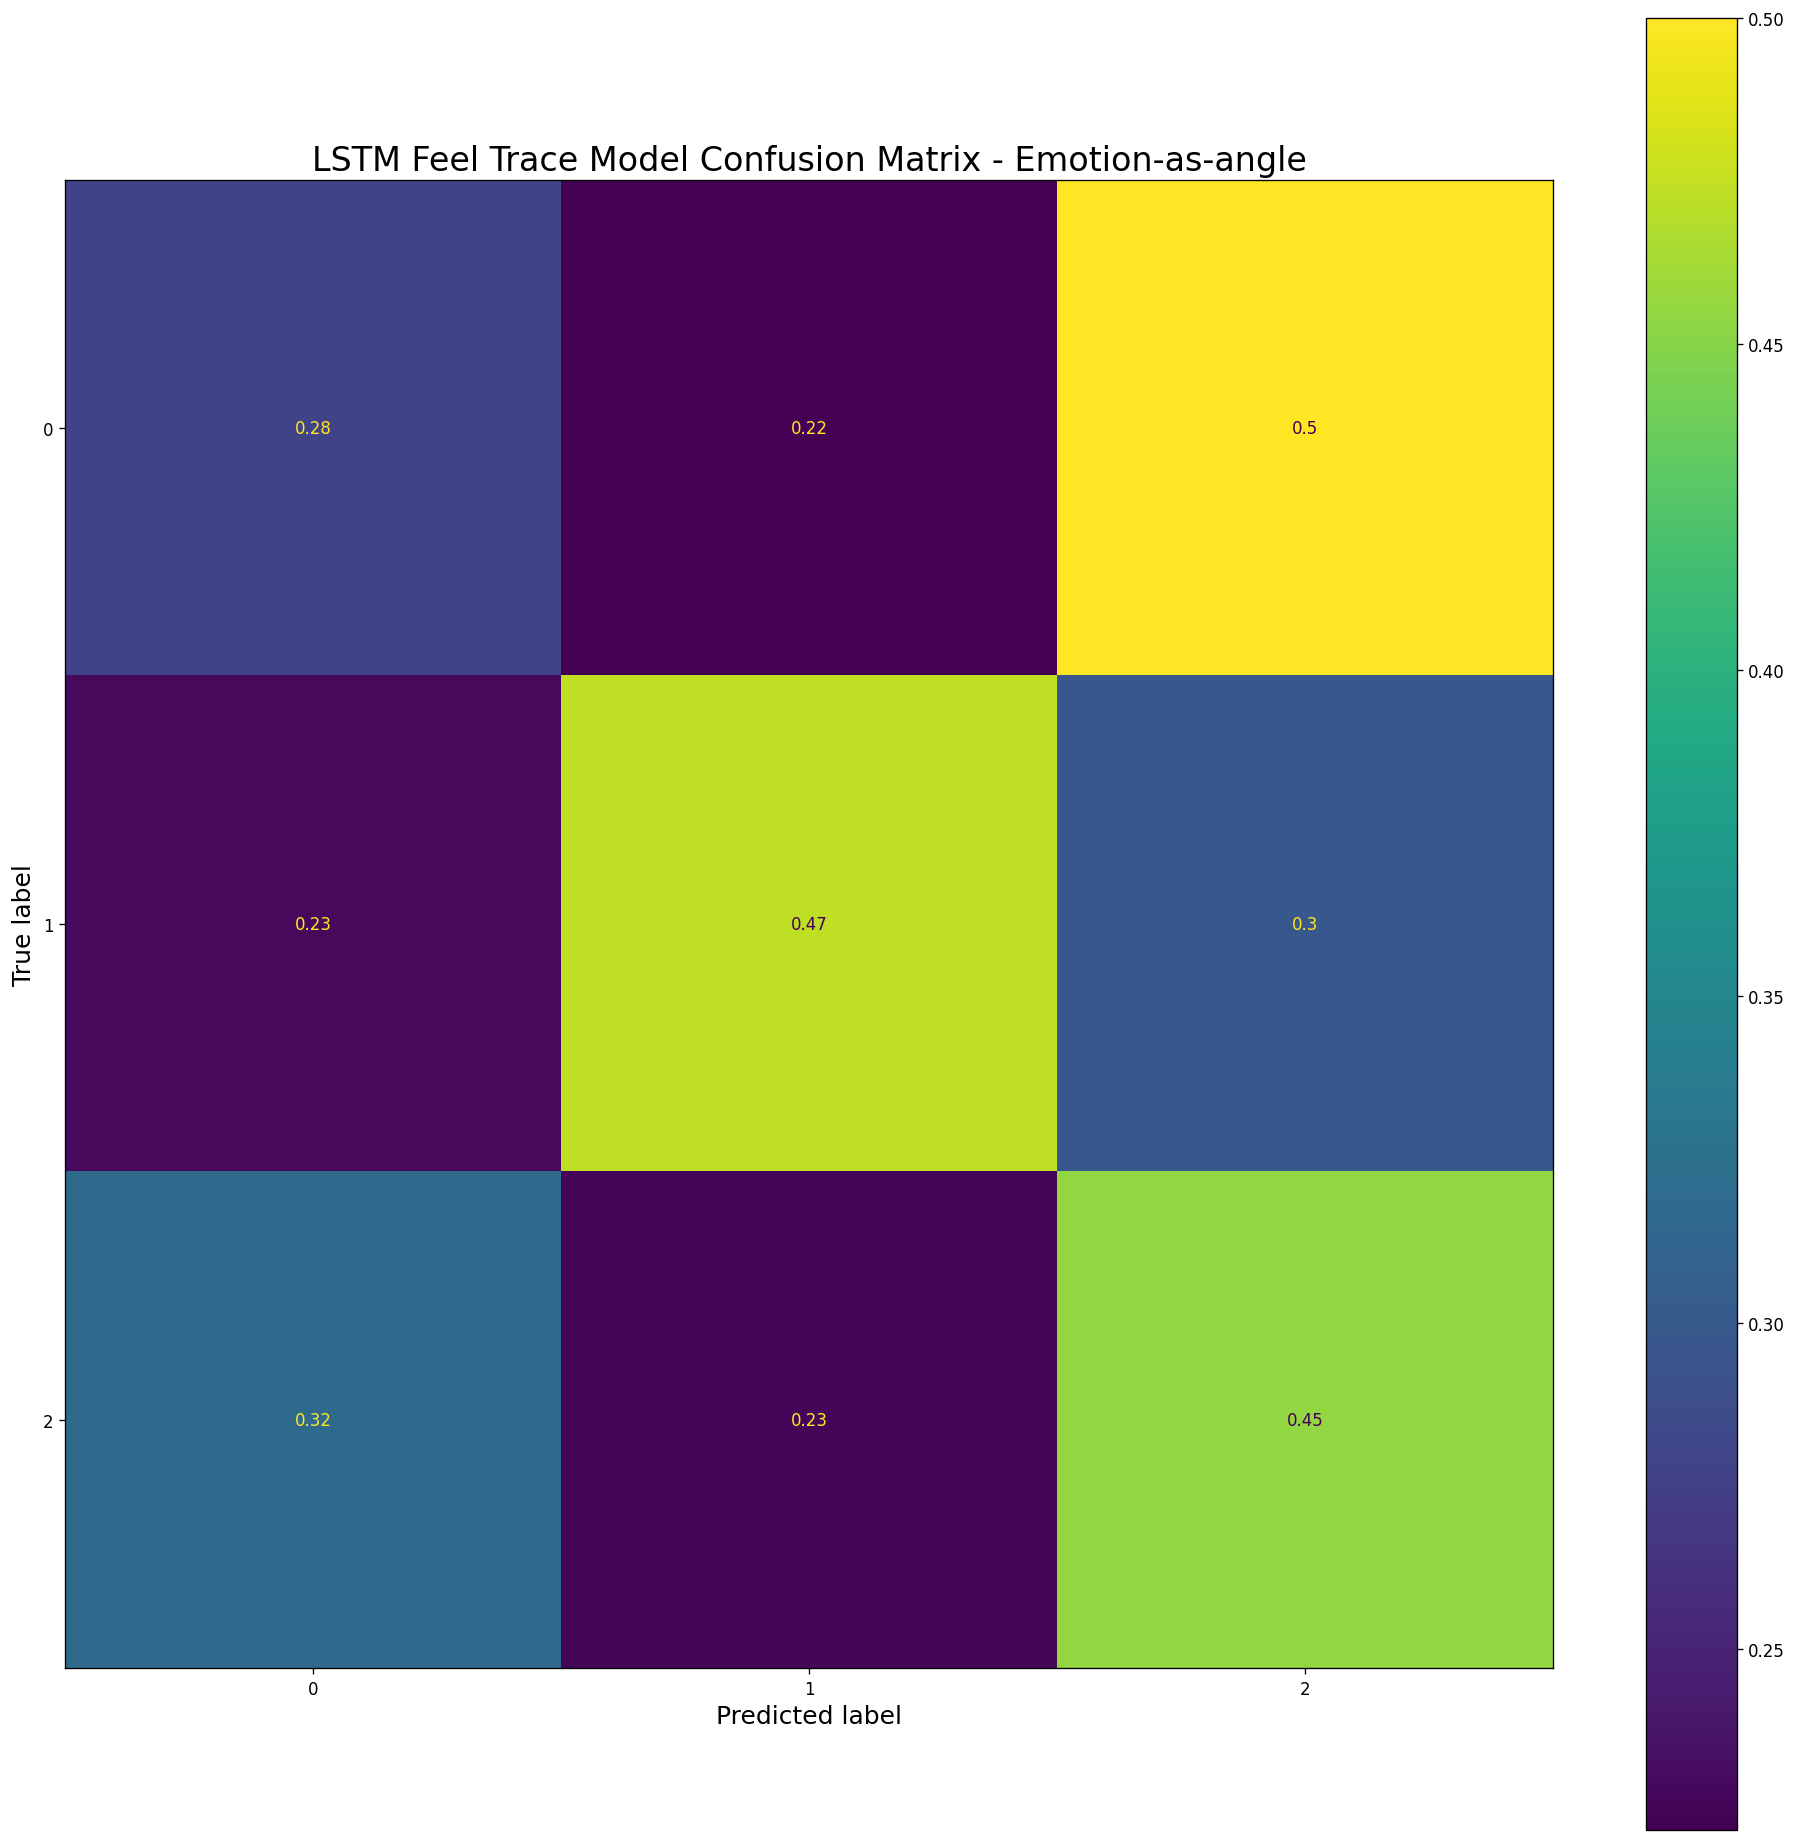

Training k=3
Training Classifier!
Train label distribution: [ 72 297  86]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Epoch:1,
Train Loss:1.7407441139221191,
Train Accuracy:0.3345070422535211,
Train Recall: 0.3410987328114649,
Train precision: 0.27751090810554757,
Train F1-Score:0.2368164527766606,


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Epoch:2,
Train Loss:1.3684313297271729,
Train Accuracy:0.3450429137323944,
Train Recall: 0.33130699088145893,
Train precision: 0.14265786761165283,
Train F1-Score:0.19335637288186402,


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch:3,
Train Loss:1.2045406103134155,
Train Accuracy:0.3477937940140845,
Train Recall: 0.34601571835646655,
Train precision: 0.34470286970286973,
Train F1-Score:0.22397313519840342,


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch:4,
Train Loss:1.1358628273010254,
Train Accuracy:0.3829775528169014,
Train Recall: 0.3938951805576092,
Train precision: 0.431930403292065,
Train F1-Score:0.29376004054413357,


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch:5,
Train Loss:1.053666591644287,
Train Accuracy:0.45799405809859156,
Train Recall: 0.4462526237956119,
Train precision: 0.5861739156534777,
Train F1-Score:0.3913290226388727,


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


Epoch:6,
Train Loss:0.9788227081298828,
Train Accuracy:0.5075649207746479,
Train Recall: 0.5113322786200937,
Train precision: 0.5358891158985268,
Train F1-Score:0.49788653003706773,


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch:7,
Train Loss:0.9627051949501038,
Train Accuracy:0.5318276848591549,
Train Recall: 0.5310922130381304,
Train precision: 0.5749349037637665,
Train F1-Score:0.51551715578766,


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch:8,
Train Loss:0.8917325139045715,
Train Accuracy:0.6064590669014085,
Train Recall: 0.6116788872763376,
Train precision: 0.6198814397665715,
Train F1-Score:0.60430009993547,


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch:9,
Train Loss:0.8494055867195129,
Train Accuracy:0.630309198943662,
Train Recall: 0.6355752063591096,
Train precision: 0.6463265096436348,
Train F1-Score:0.6276159782969177,


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch:10,
Train Loss:0.7983384728431702,
Train Accuracy:0.6807328345070423,
Train Recall: 0.6675591480836691,
Train precision: 0.6872673592803024,
Train F1-Score:0.6682761277263916,
Test label distribution: [18 74 21]
Precision: 0.36829710144927535
Recall: 0.3874588874588875
F1-Score: 0.3259175819018117
Base line F1-Score: 0.2638146167557932
Accuracy: 0.34513274336283184
Metrics:
              precision    recall  f1-score   support

           0       0.20      0.39      0.26        18
           1       0.69      0.30      0.42        74
           2       0.22      0.48      0.30        21

    accuracy                           0.35       113
   macro avg       0.37      0.39      0.33       113
weighted avg       0.52      0.35      0.37       113



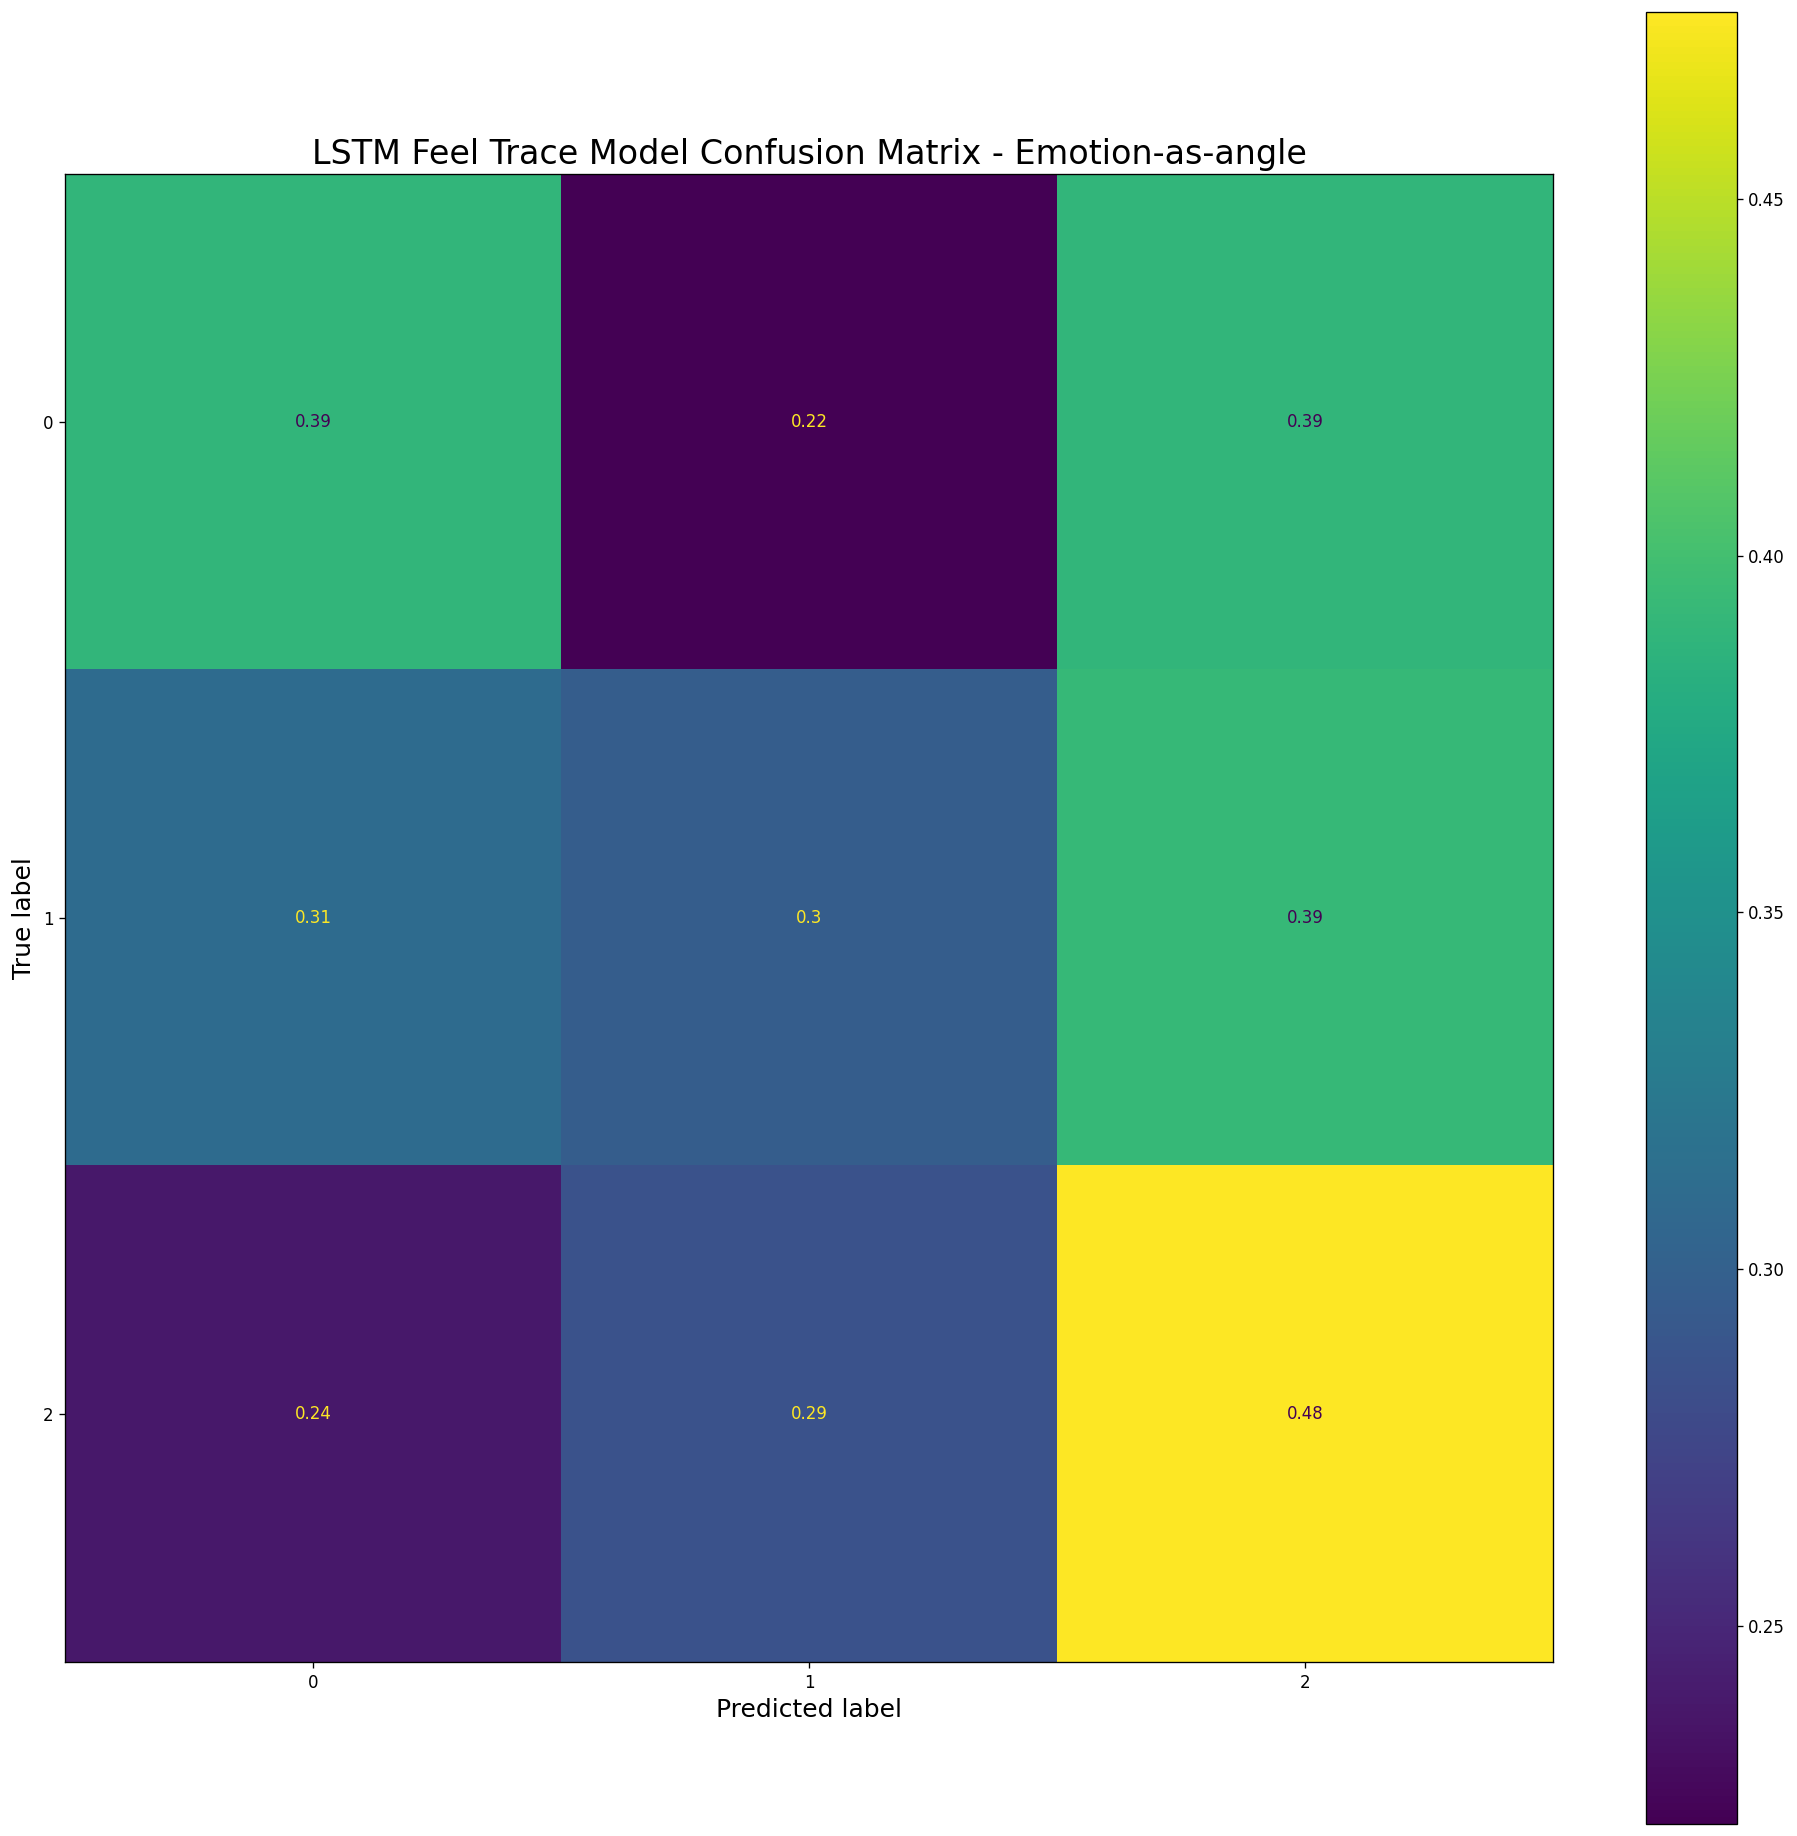

Training k=4
Training Classifier!
Train label distribution: [ 72 297  86]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch:1,
Train Loss:2.409236431121826,
Train Accuracy:0.3591274207746479,
Train Recall: 0.32819699572706046,
Train precision: 0.1677937721462015,
Train F1-Score:0.2008367182793292,


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch:2,
Train Loss:1.9562556743621826,
Train Accuracy:0.3352772887323944,
Train Recall: 0.32728866740494644,
Train precision: 0.12648627601886558,
Train F1-Score:0.17399772199635632,


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch:3,
Train Loss:1.3400770425796509,
Train Accuracy:0.3829225352112676,
Train Recall: 0.3635445890504403,
Train precision: 0.2869279517259502,
Train F1-Score:0.25030868258271144,


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Epoch:4,
Train Loss:1.3104140758514404,
Train Accuracy:0.37395466549295775,
Train Recall: 0.35330988455988455,
Train precision: 0.16154363114996656,
Train F1-Score:0.21715216219892264,


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch:5,
Train Loss:1.1051141023635864,
Train Accuracy:0.4024812940140845,
Train Recall: 0.3817658549839075,
Train precision: 0.37800819482959624,
Train F1-Score:0.2856808612030815,


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch:6,
Train Loss:1.0530662536621094,
Train Accuracy:0.4549130721830986,
Train Recall: 0.4600995754204262,
Train precision: 0.5963518690372156,
Train F1-Score:0.39289147652937184,


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Epoch:7,
Train Loss:1.0193008184432983,
Train Accuracy:0.4708956866197183,
Train Recall: 0.4653864443245197,
Train precision: 0.58787305466598,
Train F1-Score:0.4256644939547137,


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch:8,
Train Loss:0.9404098987579346,
Train Accuracy:0.565856073943662,
Train Recall: 0.5670537398706481,
Train precision: 0.5909846985576076,
Train F1-Score:0.5520609811613659,


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Epoch:9,
Train Loss:0.9425886273384094,
Train Accuracy:0.5549075704225352,
Train Recall: 0.558010207015583,
Train precision: 0.5770567573993645,
Train F1-Score:0.5399235349497028,


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch:10,
Train Loss:0.9288676381111145,
Train Accuracy:0.556062940140845,
Train Recall: 0.5578287825239044,
Train precision: 0.5708415138912738,
Train F1-Score:0.5564831576420028,
Test label distribution: [18 74 21]
Precision: 0.3901948590381426
Recall: 0.39875589875589873
F1-Score: 0.3903490474203866
Base line F1-Score: 0.2638146167557932
Accuracy: 0.5221238938053098
Metrics:
              precision    recall  f1-score   support

           0       0.19      0.17      0.18        18
           1       0.72      0.65      0.68        74
           2       0.27      0.38      0.31        21

    accuracy                           0.52       113
   macro avg       0.39      0.40      0.39       113
weighted avg       0.55      0.52      0.53       113



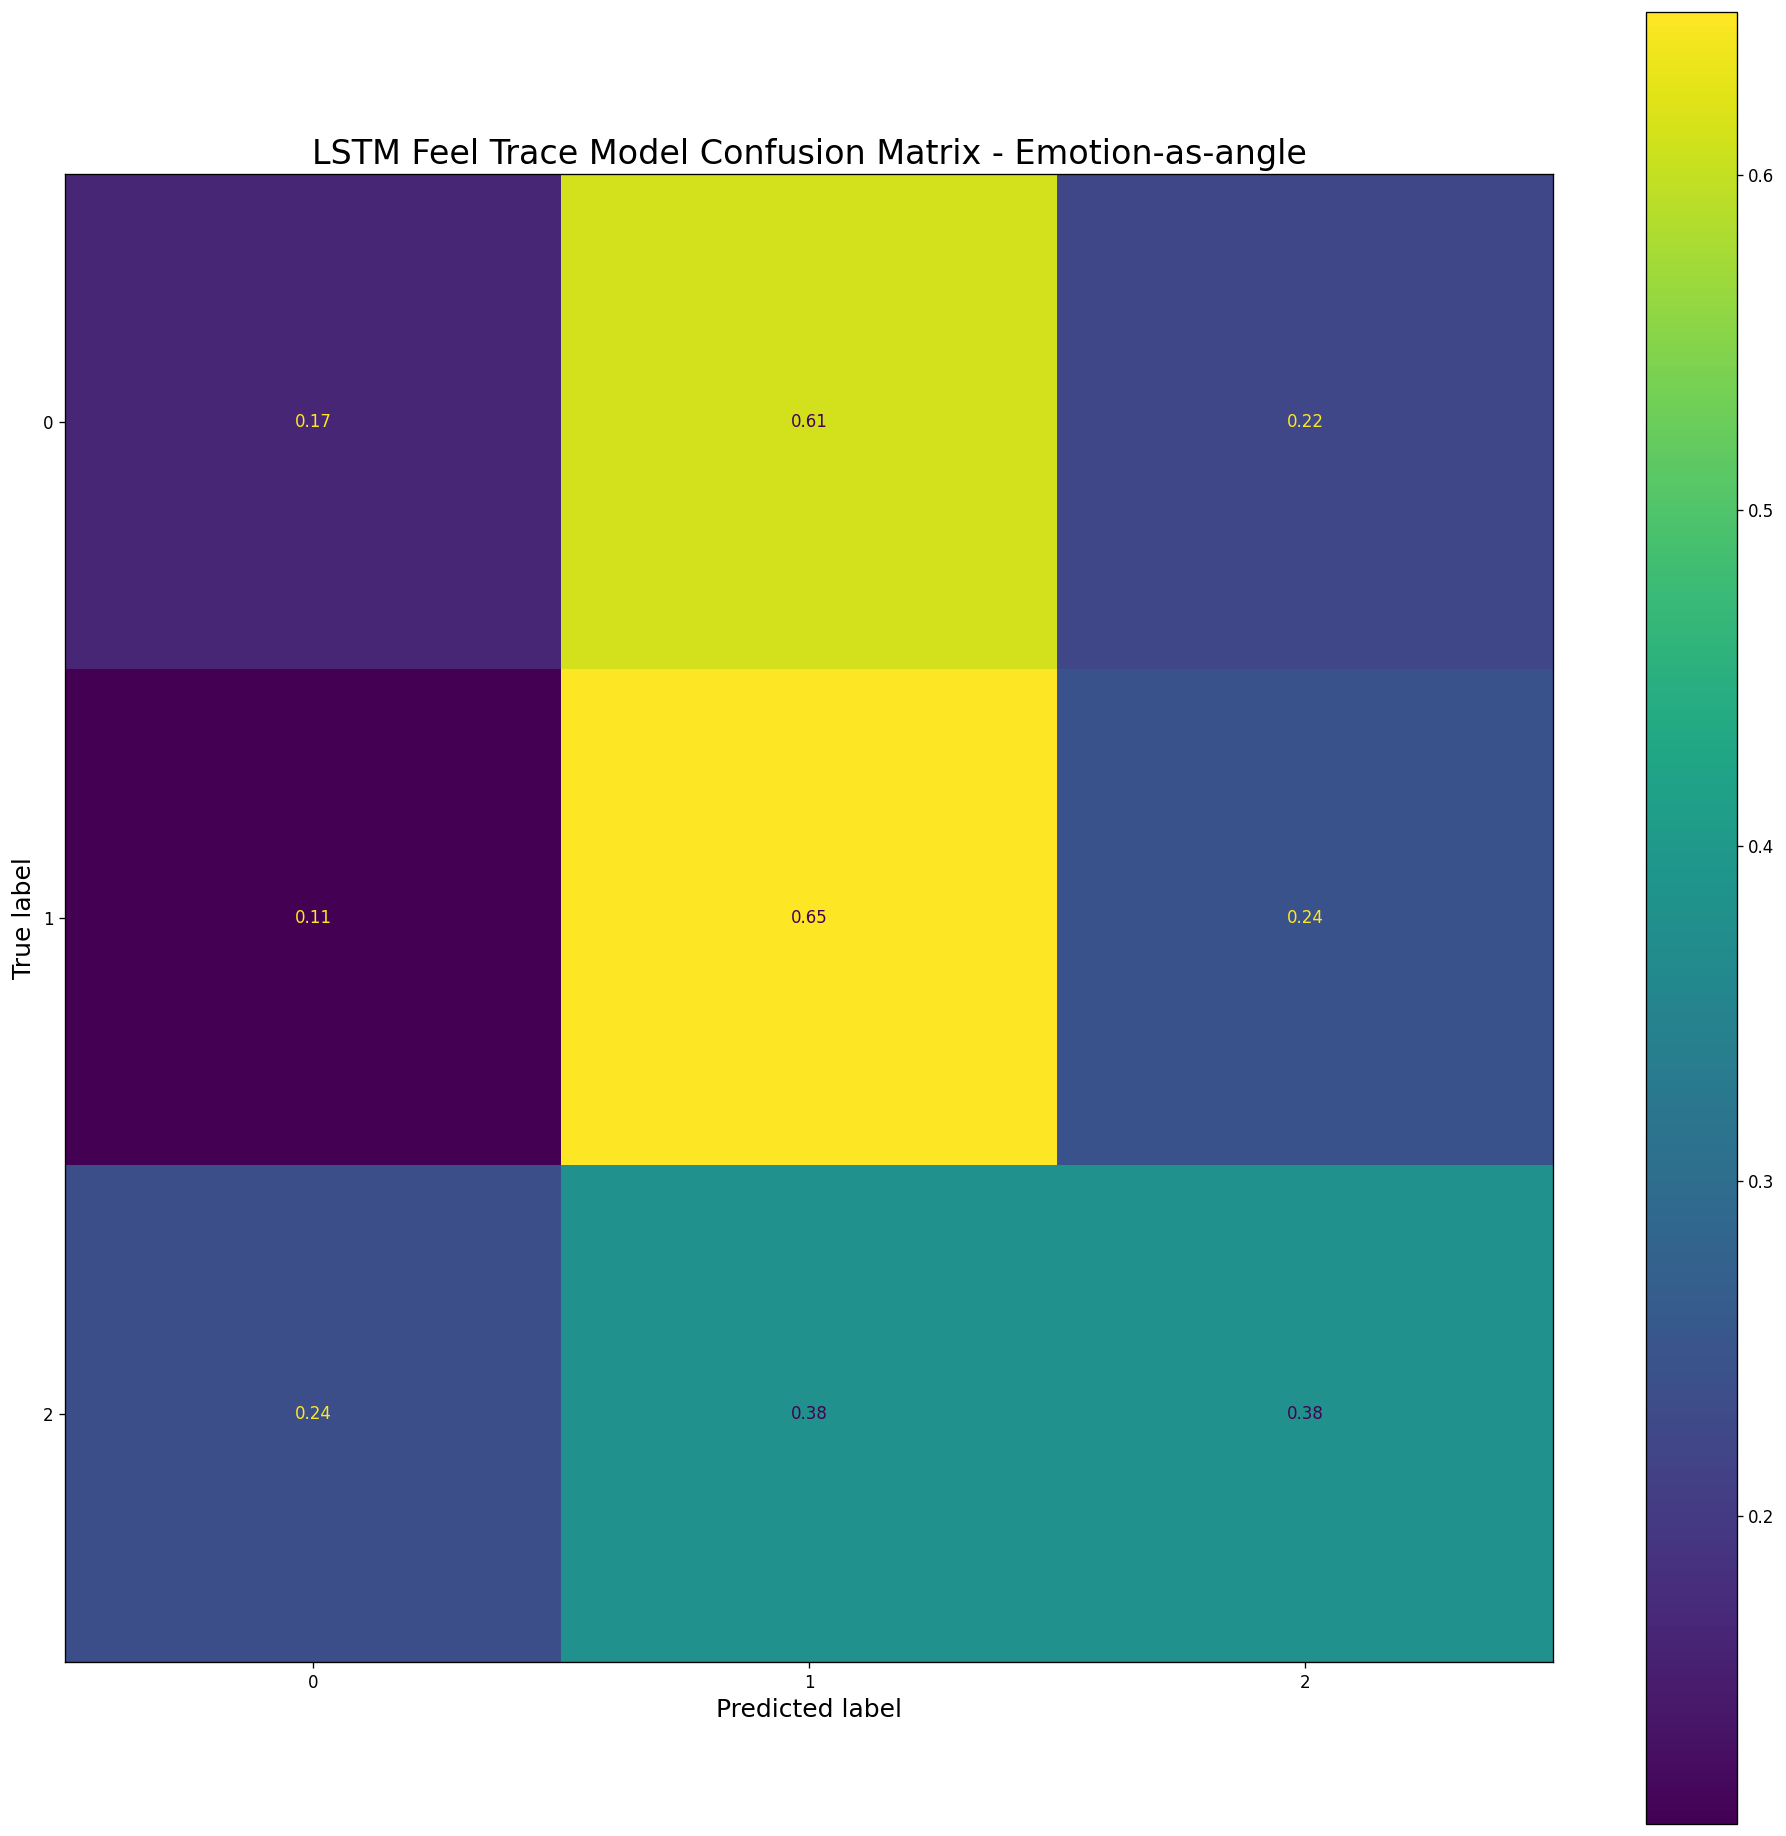

Accuracy, Average accuracy: [0.4358730158730159, 0.3367913367913367, 0.40176540176540176, 0.3874588874588875, 0.39875589875589873], 0.39212890812890816
F1-Score, Average F1-Score: [0.4353389287760811, 0.33000485403231394, 0.37448220463005893, 0.3259175819018117, 0.3903490474203866], 0.37121852335213046


In [110]:
k_acc = [] # accuracies for each fold
k_f1 = [] # f1 score for each fold

for cur_k in range(len(indices)):
    print(f"Training k={cur_k}")
    train_index, test_index = indices[cur_k]

    classifier_model = classifier(num_features=num_features, num_hidden=classifier_hidden, dropout=0.8, n_labels=num_classes)


    encoded_train_features = eeg_features[train_index]
    print('Training Classifier!')
    classifier_train_metrics = train_classifier(classifier_model, classifier_train_epochs, batch_size=128, learning_rate=classifier_learning_rate, features=encoded_train_features, labels=labels[train_index])


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_features, test_labels =  eeg_features[test_index], labels[test_index]
    print(f"Test label distribution: {np.bincount(test_labels, minlength=num_classes)}")
    encoded_test_features = test_features

    with torch.no_grad():
        classifier_model.eval()
        x_encoded  = torch.from_numpy(encoded_test_features).float().to(device)
        y = test_labels
        y_hat = classifier_model(x_encoded)
        y_hat = F.softmax(y_hat.detach(), dim=-1).cpu().numpy()
        preds = y_hat

    fig, axs = plt.subplots(figsize=(20,20), dpi=120)
    axs.set_title(f"LSTM Feel Trace Model Confusion Matrix - Emotion-as-{label_type}", fontsize=20)
    axs.set_xlabel("Predicted Label", fontsize=15)
    axs.set_ylabel("True Label", fontsize=15)


    prf = precision_recall_fscore_support(test_labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
    base_line = precision_recall_fscore_support(test_labels, np.array([1 for x in preds]), average='macro', zero_division=0)
    acc = np.mean(test_labels == np.array([x.argmax() for x in preds]))

    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F1-Score: {prf[2]}")
    print(f"Base line F1-Score: {base_line[2]}")
    print(f"Accuracy: {acc}")
    print('Metrics:')
    print(classification_report(test_labels, np.array([x.argmax() for x in preds])))


    cm = confusion_matrix(test_labels, [x.argmax() for x in preds], labels=np.arange(num_classes), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
    
    acc = np.mean(cm.diagonal())
    k_acc.append(acc)
    k_f1.append(prf[2])


    disp.plot(ax=axs)
    plt.show()

print(f"Accuracy, Average accuracy: {k_acc}, {np.mean(k_acc)}")
print(f"F1-Score, Average F1-Score: {k_f1}, {np.mean(k_f1)}")